In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

In [73]:
def generate_data(m, n):
    assert m < n, "Number of constraints must be less than number of variables."
    A = np.random.randn(m, n)
    # Ensure last row is positive => problem is bounded below
    # because 1^T x = 1 and x >= 0 restrict the feasible region to be compact
    A[m - 1, :] = np.abs(A[m - 1, :])
    assert np.linalg.matrix_rank(A) == m, "Matrix A must have full row rank."

    # x0 = np.random.rand(n) + 0.1
    # Bad conditioning so that convergence takes longer
    x0 = np.exp(np.random.randn(n) * 3)  # log-normal with high variance
    b = A @ x0
    c = np.random.randn(n)
    return A, b, c, x0

In [16]:
A, b, c, x0 = generate_data(5, 10)
x0

array([0.32908729, 1.08932178, 0.54851331, 0.89324827, 0.13206774,
       0.84375752, 0.46653848, 0.50665894, 0.16805635, 0.55262556])

In [9]:
A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 10]])
b = np.array([1, 2, 3]).reshape(-1, 1)
A * b

array([[ 1,  2,  3],
       [ 8, 10, 12],
       [21, 24, 30]])

In [66]:
def newton_centering(A, b, c, x0, *, tol=1e-6, alpha=0.2, beta=0.7):
    # m, n = A.shape

    def f(x):
        return c @ x - np.sum(np.log(x))

    def grad_f(x):
        return c - 1 / x

    # ∇²f(x) = diag(1/x ** 2)
    # ∇²f(x)^(-1) = diag(x ** 2)

    x = x0.copy()
    f_x = f(x)
    f_x_history = [f_x]
    lambda_sq_history = []

    while True:
        # Block elimination to solve KKT in O(m^3 + nm^2)
        M1 = (x**2).reshape(-1, 1) * A.T
        z1 = -(x**2) * grad_f(x)
        M2 = -A @ M1
        z2 = -A @ z1
        nu = np.linalg.solve(M2, z2)
        z3 = -grad_f(x) - A.T @ nu
        step = (x**2) * z3
        lambda_sq = step @ z3

        if lambda_sq <= tol * 2:
            break

        # Backtracking line search
        t = 1
        while np.min(x + t * step) <= 0:
            t *= beta
        while f(x + t * step) > f_x + alpha * t * grad_f(x) @ step:
            t *= beta
        x += t * step
        f_x = f(x)
        f_x_history.append(f_x)
        lambda_sq_history.append(lambda_sq)

    return x, nu, f_x_history, lambda_sq_history

CVXPY optimal point: [2.26287003e-01 1.94895912e+02 3.26627140e-01 8.20427287e-02
 2.05803419e-01] ...
Custom Newton optimal point: [2.26286955e-01 1.94895945e+02 3.26627106e-01 8.20428257e-02
 2.05803399e-01] ...


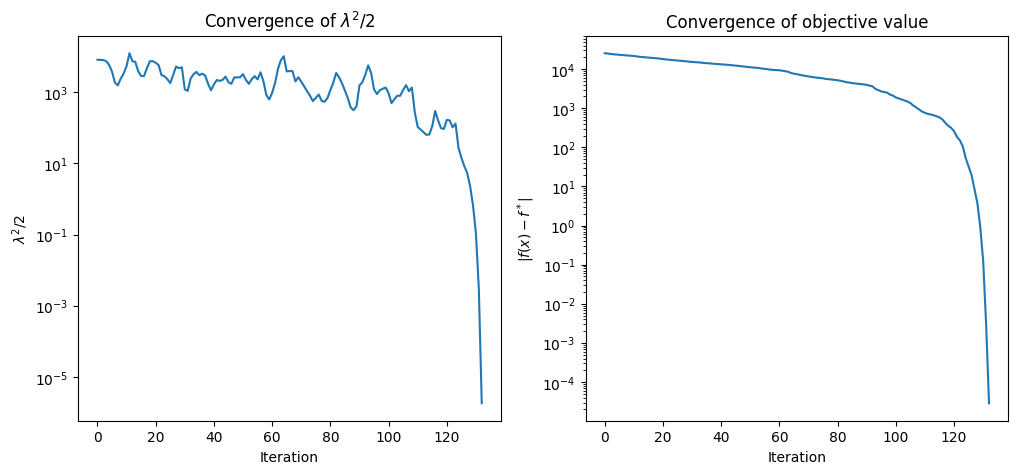

In [75]:
m, n = 100, 500
A, b, c, x0 = generate_data(m, n)
x_star, nu_star, f_x_history, lambda_sq_history = newton_centering(A, b, c, x0)

# Sanity check
x_cvx = cp.Variable(n)
constraints = [A @ x_cvx == b]
objective = cp.Minimize(c @ x_cvx - cp.sum(cp.log(x_cvx)))
problem = cp.Problem(objective, constraints)
problem.solve()
print(f"CVXPY optimal point: {x_cvx.value[:5]} ...")
print(f"Custom Newton optimal point: {x_star[:5]} ...")
assert np.allclose(x_star, x_cvx.value, rtol=1e-3)

# Plot lambda^2/2 vs iteration, and error vs iteration
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].semilogy(np.array(lambda_sq_history) / 2)
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel(r"$\lambda^2/2$")
ax[0].set_title(r"Convergence of $\lambda^2/2$")
ax[1].semilogy(np.abs(np.array(f_x_history[:-1]) - problem.value))
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel(r"$|f(x) - f^*|$")
ax[1].set_title("Convergence of objective value")
plt.show()